<a href="https://colab.research.google.com/github/vjsurampudi/END/blob/main/Session14/Chatbot4CodeGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.data import Field, BucketIterator
from torch.utils.data import DataLoader
from torchtext.legacy.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tokenize import tokenize
from io import BytesIO

import random
import math
import time
from google.colab import drive
import os
from torchtext.legacy.data import Example

In [2]:
torch.__version__

'1.8.1+cu101'

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.chdir('gdrive/MyDrive/END_Capstone')
os.listdir('.')

['conala-corpus',
 'english_python_data_v1.txt',
 '.ipynb_checkpoints',
 'english_python_data.txt',
 'PreProcessedDataSet.txt',
 'Conala.zip',
 'tut6m-model.pt']

To augment the current dataset, we look for additional datasets. Carnegie Mellon University released a dataset crawled from Stack Overflow and annotated. The dataset is available at: https://conala-corpus.github.io/

We attempt to add the data to our existing data to create a larger dataset

In [5]:
# Getting the CoNaLa corpus
!wget -O Conala.zip "http://www.phontron.com/download/conala-corpus-v1.1.zip"

--2021-04-01 08:15:16--  http://www.phontron.com/download/conala-corpus-v1.1.zip
Resolving www.phontron.com (www.phontron.com)... 208.113.196.149
Connecting to www.phontron.com (www.phontron.com)|208.113.196.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52105440 (50M) [application/zip]
Saving to: ‘Conala.zip’

Conala.zip          100%[===================>]  49.69M  53.5MB/s    in 0.9s    

2021-04-01 08:15:17 (53.5 MB/s) - ‘Conala.zip’ saved [52105440/52105440]



In [6]:
# Unzipping CoNaLa corpus
!unzip -n Conala.zip

Archive:  Conala.zip


In [7]:
!head conala-corpus/conala-train.json

[
  {
    "intent": "How to convert a list of multiple integers into a single integer?",
    "rewritten_intent": "Concatenate elements of a list 'x' of multiple integers to a single integer",
    "snippet": "sum(d * 10 ** i for i, d in enumerate(x[::-1]))",
    "question_id": 41067960
  },
  {
    "intent": "How to convert a list of multiple integers into a single integer?",
    "rewritten_intent": "convert a list of integers into a single integer",


Create a list of titles (intent) and corresponding code snippet from Conala Dataset which is in JSON format

In [9]:
questions, answers = [],[]

# loading train json
import json
f = open("conala-corpus/conala-train.json","r")
train_file = json.load(f)
f.close()

for num,intent in enumerate(train_file):
  if intent['intent'] is not None:
    questions.append(intent['intent'])
    answers.append(intent['snippet'])
  if intent['rewritten_intent'] is not None:
    questions.append(intent['rewritten_intent'])
    answers.append(intent['snippet'])

# loading train json
f = open("conala-corpus/conala-test.json","r")
test_file = json.load(f)
f.close()

for num,intent in enumerate(test_file):
  if intent['intent'] is not None:
    questions.append(intent['intent'])
    answers.append(intent['snippet'])
  if intent['rewritten_intent'] is not None:
    questions.append(intent['rewritten_intent'])
    answers.append(intent['snippet'])

In [10]:
questions[:10], answers[:10]

(['How to convert a list of multiple integers into a single integer?',
  "Concatenate elements of a list 'x' of multiple integers to a single integer",
  'How to convert a list of multiple integers into a single integer?',
  'convert a list of integers into a single integer',
  'how to convert a datetime string back to datetime object?',
  "convert a DateTime string back to a DateTime object of format '%Y-%m-%d %H:%M:%S.%f'",
  'Averaging the values in a dictionary based on the key',
  'get the average of a list values for each key in dictionary `d`)',
  'zip lists in python',
  'zip two lists `[1, 2]` and `[3, 4]` into a list of two tuples containing elements at the same index in each list'],
 ['sum(d * 10 ** i for i, d in enumerate(x[::-1]))',
  'sum(d * 10 ** i for i, d in enumerate(x[::-1]))',
  "r = int(''.join(map(str, x)))",
  "r = int(''.join(map(str, x)))",
  "datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f')",
  "datetime.strptime('2010-11-13 10:33:54.22

In [11]:
len(questions), len(answers)

(5656, 5656)

Reading Code question and the python code from the provided file which is preprocessed as follows:
1. Replaced # on title line with #$$$ to distinguish from inline comments in code and title line
2. Remove duplicate code snippets

In [13]:

qlist = []
alist = []
with open(os.path.join("", "PreProcessedDataSet.txt"), "r") as f:
  data = f.readlines()
line = False
for QCode in data:
  if QCode.startswith("#$$$"):
    temp = ' '.join(Q for Q in QCode.split()[1:])
    qlist.append(temp)
    if line == False:
      Alist = []
      line  = True
    else:
      alist.append(''.join(ans for ans in Alist))
      Alist = []
  else:
    Alist.append(QCode)
alist.append(''.join(ans for ans in Alist))

In [14]:
qlist.extend(questions)
alist.extend(answers)
print(len(qlist), len(alist))

9980 9980


Using Spacy to tokenize the text for the title and python tokenizer for the code snippet

In [17]:
spacy_en = spacy.load('en')

In [23]:
def tokenize_en(text):
  """
  Tokenizes English text from a string into a list of strings
  """
  return [tok.text for tok in spacy_en.tokenizer(text)]

def codetokenize(text):
 # """
  #Tokenizes the python code 
  #"""
  tokens = []
  a = list(tokenize(BytesIO(text.encode('utf-8')).readline))
  for i__ in a[1:-1]:
      if i__.exact_type == 3:
          string_tokens = [k__ for k__ in i__[1]]
          tokens = tokens + string_tokens
      elif i__.exact_type == 6:   
          continue
      else:
          tokens.append(i__[1])
  return tokens

In [20]:
qlist[9000]

"MySQL execute query 'SELECT * FROM foo WHERE bar = %s AND baz = %s' with parameters `param1` and `param2`"

In [24]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = codetokenize,       #tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

fields = [('src', SRC), ('trg', TRG)]
Gensample = [Example.fromlist([qlist[k], alist[k]], fields) for k in range(len(qlist))] 
dataset = Dataset(Gensample, fields=fields)
#Tdata, test_data = dataset.split(0.9)
#train_data, valid_data = Tdata.split(0.8)
train_data, valid_data = dataset.split(0.8)

In [25]:
## Building vocabulary
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 10)

In [26]:
len(SRC.vocab), len(TRG.vocab)

(2376, 899)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
BATCH_SIZE = 16

#train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
 #   (train_data, valid_data, test_data), 
  #   batch_size = BATCH_SIZE,
   #  sort_key = lambda x: len(x.trg),
    # device = device)

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.trg),
     device = device)

In [29]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [31]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [33]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [34]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [35]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [36]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
max_length = 3000

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length)

In [37]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,607,491 trainable parameters


In [39]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [40]:
model.apply(initialize_weights);

In [41]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [43]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [44]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6m-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 35s
	Train Loss: 3.281 | Train PPL:  26.590
	 Val. Loss: 2.331 |  Val. PPL:  10.290
Epoch: 02 | Time: 0m 35s
	Train Loss: 2.405 | Train PPL:  11.076
	 Val. Loss: 1.999 |  Val. PPL:   7.384
Epoch: 03 | Time: 0m 36s
	Train Loss: 2.132 | Train PPL:   8.430
	 Val. Loss: 1.803 |  Val. PPL:   6.070
Epoch: 04 | Time: 0m 36s
	Train Loss: 1.947 | Train PPL:   7.008
	 Val. Loss: 1.677 |  Val. PPL:   5.349
Epoch: 05 | Time: 0m 36s
	Train Loss: 1.810 | Train PPL:   6.112
	 Val. Loss: 1.583 |  Val. PPL:   4.870
Epoch: 06 | Time: 0m 36s
	Train Loss: 1.699 | Train PPL:   5.466
	 Val. Loss: 1.516 |  Val. PPL:   4.554
Epoch: 07 | Time: 0m 36s
	Train Loss: 1.599 | Train PPL:   4.948
	 Val. Loss: 1.456 |  Val. PPL:   4.290
Epoch: 08 | Time: 0m 36s
	Train Loss: 1.517 | Train PPL:   4.558
	 Val. Loss: 1.396 |  Val. PPL:   4.040
Epoch: 09 | Time: 0m 36s
	Train Loss: 1.445 | Train PPL:   4.240
	 Val. Loss: 1.372 |  Val. PPL:   3.941
Epoch: 10 | Time: 0m 36s
	Train Loss: 1.381 | Train PPL

In [1]:
model.load_state_dict(torch.load('tut6m-model.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

NameError: ignored

In [ ]:
def encode_inputs(input,vocab):

  tokenized_input = [tok.text.lower() for tok in spacy_en.tokenizer(input)]
  tokenized_input = ['<sos>'] + tokenized_input +['<eos>']

  numericalized_input = [vocab[i] for i in tokenized_input]

  tensor_input = torch.LongTensor([numericalized_input])
  
  return tensor_input

In [ ]:
def decode_outputs(output,vocab):
  predicted_token = output.argmax(-1)
  return vocab[predicted_token.item()], predicted_token

In [ ]:
print(" Enter q or Q or QUIT or Quit or quit to exit.")

answer_max_len = 3000
stoi = SRC.vocab.stoi
itos = TRG.vocab.itos

while(True):

  input_ = input("Enter the Question:")

  if input_=='q' or input_=='Q' or input_=='Quit' or input_=='QUIT' or input_=='quit':
    break

  src = encode_inputs(input_,stoi).to(device)
  src_mask = model.make_src_mask(src)

  with torch.no_grad():
    enc_src = model.encoder(src,src_mask)
  
  trg = '<sos>'
  trg_indexes = [stoi[trg]]

  decoder_outputs = []
  for i in range(answer_max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    trg_mask = model.make_trg_mask(trg_tensor)
    
    with torch.no_grad():
      decoder_output, attention = model.decoder(trg_tensor,enc_src,trg_mask,src_mask)

    pred_token = decoder_output.argmax(2)[:,-1].item()

    if pred_token == TRG.vocab.stoi[TRG.eos_token]:
      break
    decoder_outputs.append(itos[pred_token])
    trg_indexes.append(pred_token)

    
  print("Answer ----->:")
  print(" "+" ".join(decoder_outputs))


 Enter q or Q or QUIT or Quit or quit to exit.
Enter the Question:Python program to find the sum of two numbers
Answer ----->:
 num1 = <unk> 
 num2 = <unk> 
 sum = num1 + num2 
 print ( f ' S u m :   { s u m } ' ) 
Enter the Question:python function to find the factorial of a number
Answer ----->:
 def factorial ( n ) : 
      if n == 0 or n == 1 : 
          return 1 
 else : 
          return n * factorial ( n - 1 ) 
Enter the Question:q
 Enter q or Q or QUIT or Quit or quit to exit.


In [ ]:
def prediction(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 20

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['delete', 'a', 'list', 'element', 'by', 'value']
trg = ['if', '(', 'c', 'in', 'a', ')', ':', '\n', '    ', 'a', '.', 'remove', '(', 'c', ')', '']


In [ ]:
predict, attention = prediction(src, SRC, TRG, model, device, max_length)

print(f'predicted trg = {predict}')

predicted trg = ['a', '.', 'remove', '(', 'c', ')', '', '<eos>']


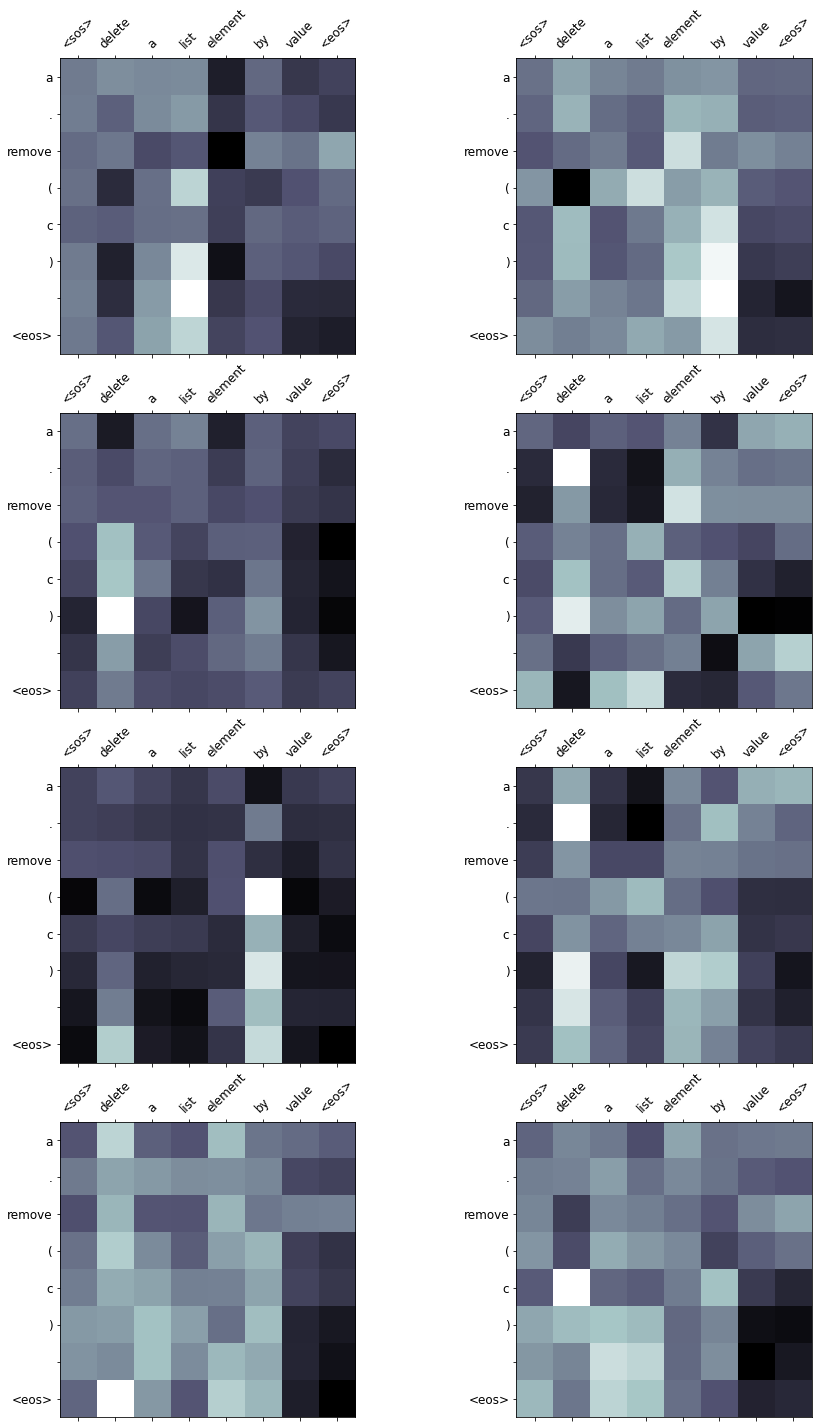

In [ ]:
display_attention(src, predict, attention)